In [6]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from scipy.cluster.hierarchy import linkage,leaves_list,optimal_leaf_ordering
from scipy.spatial.distance import pdist

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

### Plot  tensor components

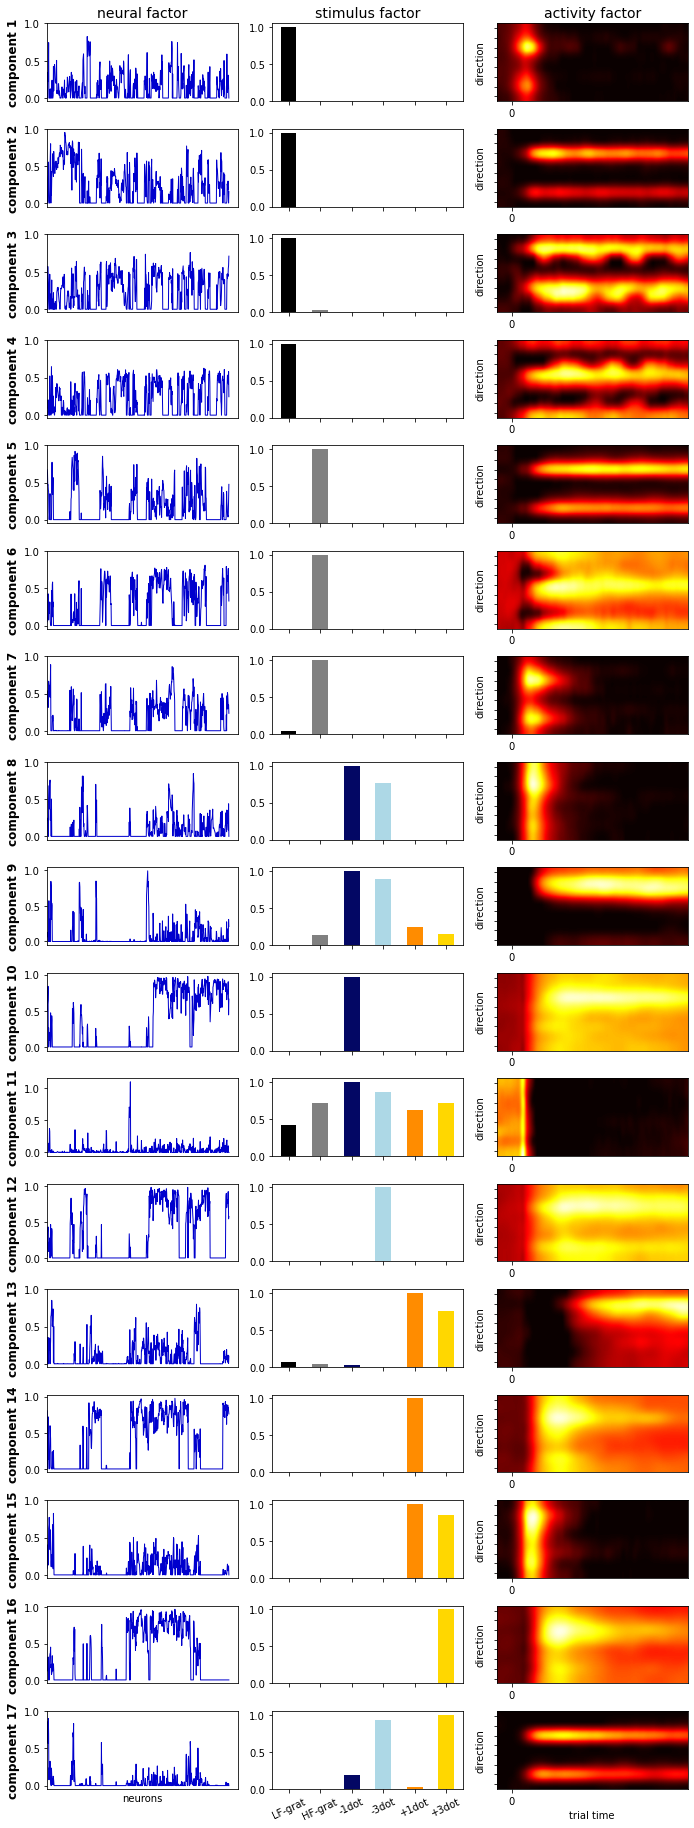

In [7]:
#PLOT FACTORS

R = 17
best_factors = np.load(f'cp-files/R{R}_factors.npy',allow_pickle=True)
best_lambdas = np.load(f'cp-files/R{R}_lambdas.npy',allow_pickle=True)


posnorms = ~np.isclose(best_lambdas,0)
best_lambdas = best_lambdas[posnorms]
nfactors = [f[:,posnorms]/np.linalg.norm(f[:,posnorms],axis=0,keepdims=1) for f in best_factors]



my_stims = ['LF-grat', 'HF-grat', '-1dot', '-3dot', '+1dot', '+3dot']

NSTIMS = len(my_stims)
NDIRS = 8


colors = ['k','gray','xkcd:darkblue','lightblue','darkorange','gold']
assert len(colors) >= NSTIMS

ncols = 3; colsz = 3.25
nrows = R; rowsz = 1.5

#sort factors by predominant stimulus (%)
sorted_factors_full = np.argsort((nfactors[1]).argmax(axis=0))


#rebalance factor loadings, scale by lambdas
stim_factors = nfactors[1].copy()
stim_scls = stim_factors.max(0,keepdims=1)
stim_factors /= stim_scls

neural_factors = nfactors[0].copy()
neural_factors *= best_lambdas
neural_factors *= stim_scls

#to improve visualization, find a global sorting of the neurons
# by running a hierarchical clustering based on the distance 
# between their neural coefficients across all components
flat_dist_mat = pdist(neural_factors)
Z = linkage(flat_dist_mat, method='complete')
leaves = leaves_list(optimal_leaf_ordering(Z, flat_dist_mat))

YLBL_SZ = 10
TITL_SZ = 14
COMP_SZ = 12
OPT_DIR = 7

lll = 0 #global count of components plotted so far

for fig_i,sorted_factors in enumerate([sorted_factors_full]):
    nrows = len(sorted_factors)
    fig,axes = plt.subplots(nrows,ncols,figsize=(colsz*ncols,nrows*rowsz))
    for ll,l in enumerate(sorted_factors):
        lll += 1
        ax = axes[ll,0]

        ax.set_ylabel(f'component {lll}', fontweight='bold', fontsize=COMP_SZ)

        ax.plot(neural_factors[leaves,l],lw=1,c='mediumblue')
        ax.set_xlim(0,ax.get_xlim()[1])
        ax.set_xticks([])
        if ll == 0:
            ax.set_title(f'neural factor',size=TITL_SZ)
        if l == sorted_factors[-1]:
            ax.set_xlabel('neurons')
        ax.set_yticks([0,.5,1.])
        ax.tick_params(axis='y', labelsize=YLBL_SZ)
        

        ax = axes[ll,1]
        ax.bar(range(NSTIMS),stim_factors[:,l],width=.5,
                color=colors)
        ax.set_xticks(range(NSTIMS))
        if l == sorted_factors[-1]:
            ax.set_xticklabels(my_stims)
            ax.tick_params(axis='x', labelrotation=25)
        else:
            ax.set_xticklabels(['']*NSTIMS)
        if ll == 0:
            ax.set_title(f'stimulus factor',size=TITL_SZ)
        ax.set_yticks([0,.5,1.])
        ax.tick_params(axis='y', labelsize=YLBL_SZ)

        ax = axes[ll,2]
        if ll == 0:
            ax.set_title(f'activity factor',size=TITL_SZ)
        pst = nfactors[2][:,l].reshape(NDIRS,-1,order='F')
        #circular-shift all response maps to same global opt dir (for better visualization)
        pst = np.roll(pst,(2-OPT_DIR)%NDIRS,0)

        ax.imshow(pst,aspect='auto',interpolation='quadric',cmap='hot',vmin=0)
        ax.set_yticks(range(NDIRS))
        ax.set_yticklabels(['']*NDIRS)
        ax.set_xticks([])
        ax.set_ylabel('direction');
        if l == sorted_factors[-1]:
            ax.set_xlabel('trial time')
        start_bin = 10
        ax.set_xticks([start_bin])
        ax.set_xticklabels(['0'])
        ax.tick_params(axis='x', labelsize=YLBL_SZ)
    fig.tight_layout()
    plt.show()

